<p style="font-size:36px;text-align:center"> <b>Personalized cancer diagnosis</b> </p>

<h2>Description</h2>

<p> Source: https://www.kaggle.com/c/msk-redefining-cancer-treatment/ </p>
<p> Data: Memorial Sloan Kettering Cancer Center (MSKCC)</p>
<p> Download training_variants.zip and training_text.zip from Kaggle.</p> 


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
#from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")

#from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression


In [2]:
dv=pd.read_csv('training_variants')
print(dv.columns)
print('Number of data points : ', dv.shape[0])
print('Number of features : ', dv.shape[1])
dv.head(3)

Index(['ID', 'Gene', 'Variation', 'Class'], dtype='object')
Number of data points :  3321
Number of features :  4


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2


In [3]:
dt =pd.read_csv("training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)
print('Number of data points : ', dt.shape[0])
print('Number of features : ', dt.shape[1])
print('Features : ', dt.columns.values)
dt.head()

Number of data points :  3321
Number of features :  2
Features :  ['ID' 'TEXT']


,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [4]:
stop=set(stopwords.words('english'))
def clean(s):
    s=s.lower()
    s=s.split()
    l=[]
    for i in s:
        if i not in stop:
            c=re.sub('[^A-Za-z0-9\n]',' ',i)
            l.append(c)
    k=""
    for i in l:
        k=k+" "+i
    k = re.sub('\s+',' ', k)
    return k
#clean("Cyclin-dependent kinases (CDKs) regulate")

In [5]:
final=pd.merge(dv,dt,on='ID',how='left')

In [6]:
for _ in range(len(final)):  
    if type(final.TEXT[_]) is str:
        final.TEXT[_]=clean(final.TEXT[_])
    else:
        print("Value is nan at ",_)

Value is nan at  1109
Value is nan at  1277
Value is nan at  1407
Value is nan at  1639
Value is nan at  2755


In [7]:
final.head(2)

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variet...
1,1,CBL,W802*,2,abstract background non small cell lung cance...


In [8]:
final[final.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [9]:
final.loc[final['TEXT'].isnull(),'TEXT'] = final['Gene'] +' '+final['Variation']

In [10]:
final.TEXT[1109]

'FANCA S1088F'

In [11]:
y_true = final['Class'].values
final.Gene      = final.Gene.str.replace('\s+', '_')
final.Variation = final.Variation.str.replace('\s+', '_')

In [12]:
X_train, X_test, y_train, y_test = train_test_split(final, y_true, stratify=y_true, test_size=0.2)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
X_train, x_cv, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

In [13]:
print('Number of data points in train data:', X_train.shape[0])
print('Number of data points in test data:', X_test.shape[0])
print('Number of data points in cross validation data:', x_cv.shape[0])

Number of data points in train data: 2124
Number of data points in test data: 665
Number of data points in cross validation data: 532


In [14]:
train_df=X_train
test_df=X_test
cv_df=x_cv

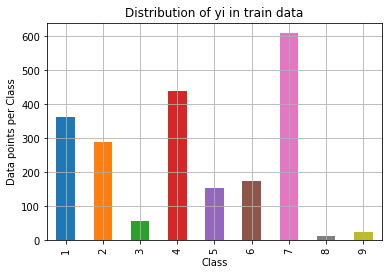

Number of data points in class 7 : 609 ( 28.672 %)
Number of data points in class 4 : 439 ( 20.669 %)
Number of data points in class 1 : 363 ( 17.09 %)
Number of data points in class 2 : 289 ( 13.606 %)
Number of data points in class 6 : 176 ( 8.286 %)
Number of data points in class 5 : 155 ( 7.298 %)
Number of data points in class 3 : 57 ( 2.684 %)
Number of data points in class 9 : 24 ( 1.13 %)
Number of data points in class 8 : 12 ( 0.565 %)
--------------------------------------------------------------------------------


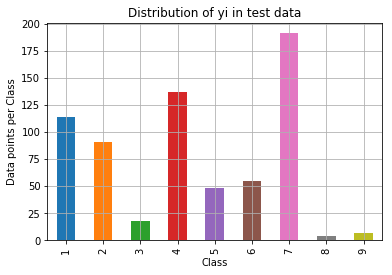

Number of data points in class 7 : 191 ( 28.722 %)
Number of data points in class 4 : 137 ( 20.602 %)
Number of data points in class 1 : 114 ( 17.143 %)
Number of data points in class 2 : 91 ( 13.684 %)
Number of data points in class 6 : 55 ( 8.271 %)
Number of data points in class 5 : 48 ( 7.218 %)
Number of data points in class 3 : 18 ( 2.707 %)
Number of data points in class 9 : 7 ( 1.053 %)
Number of data points in class 8 : 4 ( 0.602 %)
--------------------------------------------------------------------------------


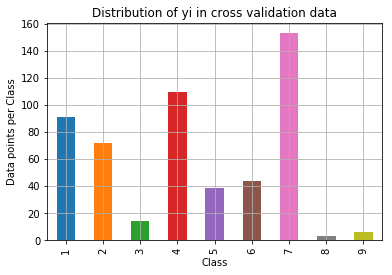

Number of data points in class 7 : 153 ( 28.759 %)
Number of data points in class 4 : 110 ( 20.677 %)
Number of data points in class 1 : 91 ( 17.105 %)
Number of data points in class 2 : 72 ( 13.534 %)
Number of data points in class 6 : 44 ( 8.271 %)
Number of data points in class 5 : 39 ( 7.331 %)
Number of data points in class 3 : 14 ( 2.632 %)
Number of data points in class 9 : 6 ( 1.128 %)
Number of data points in class 8 : 3 ( 0.564 %)


In [15]:
# it returns a dict, keys as class labels and values as the number of data points in that class
train_class_distribution = X_train['Class'].value_counts().sortlevel()
test_class_distribution = X_test['Class'].value_counts().sortlevel()
cv_class_distribution = x_cv['Class'].value_counts().sortlevel()

my_colors = 'rgbkymc'
train_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',train_class_distribution.values[i], '(', np.round((train_class_distribution.values[i]/train_df.shape[0]*100), 3), '%)')

    
print('-'*80)
my_colors = 'rgbkymc'
test_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in test data')
plt.grid()
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',test_class_distribution.values[i], '(', np.round((test_class_distribution.values[i]/test_df.shape[0]*100), 3), '%)')

print('-'*80)
my_colors = 'rgbkymc'
cv_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in cross validation data')
plt.grid()
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',cv_class_distribution.values[i], '(', np.round((cv_class_distribution.values[i]/cv_df.shape[0]*100), 3), '%)')


In [16]:
# making a Random classifier as log_loss have a range of 0 to infinity.
#So with random model we will know the outer limit of our model.

In [17]:
test_len=len(X_test)
cv_len=len(x_cv)
cv_predicted_y = np.zeros((cv_len,9))                               #creating an array of len cv_len with 9 columns
for _ in range(cv_len):
    rand_probs = np.random.rand(1,9)                                #randomly generating values b/w o and 1
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])     #normalizing them i.e their sum should be equal to 1
print("Log loss on Cross Validation Data using Random Model",log_loss(y_cv,cv_predicted_y,))


test_predicted_y=np.zeros((test_len,9))                             #same thing for test dataset
for _ in range(test_len):
    rand_probs = np.random.rand(1,9)                                
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])  
print("Log loss on Test Data using Random Model",log_loss(y_test,test_predicted_y))

Log loss on Cross Validation Data using Random Model 2.1976083847463683
Log loss on Test Data using Random Model 2.1966050677870026


In [18]:
#now we know that with random model we are getting log_loss of 2.19 so model should be between 0 and 2.1

In [19]:
#Feature Engineering
#Lets start with Gene

In [20]:
g=X_train.Gene.value_counts()
g.head(10)     # top 10 genes

BRCA1     165
TP53      108
EGFR       91
BRCA2      82
PTEN       81
KIT        68
BRAF       63
ALK        50
ERBB2      46
PDGFRA     39
Name: Gene, dtype: int64

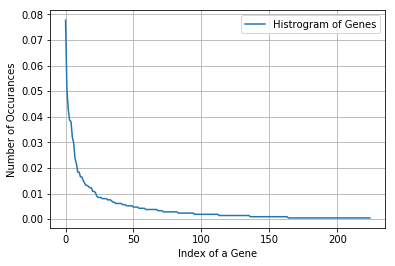

In [21]:
s=sum(g)
h=g.values/s
plt.plot(h, label="Histrogram of Genes")
plt.xlabel('Index of a Gene')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()

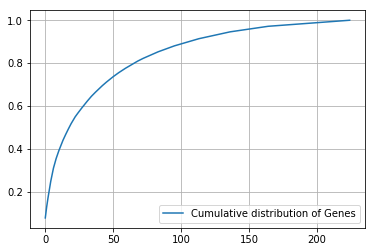

In [22]:
c = np.cumsum(h)
plt.plot(c,label='Cumulative distribution of Genes')
plt.grid()
plt.legend()
plt.show()

In [23]:
#one hot encoding of gene feature
cvect=CountVectorizer()
train_gene_vect=cvect.fit_transform(X_train.Gene)
cv_gene_vect=cvect.transform(x_cv.Gene)
test_gene_vect=cvect.transform(X_test.Gene)

In [24]:
train_gene_vect.shape

(2124, 225)

In [25]:
#Now to know the importance of gene we are going to make a logistic regression model withonly gene to predict the label

For values of alpha =  1e-05 The log loss is: 1.396030407718631
For values of alpha =  0.0001 The log loss is: 1.3515045532411576
For values of alpha =  0.001 The log loss is: 1.4653851078793256
For values of alpha =  0.01 The log loss is: 1.5276043536025754
For values of alpha =  0.1 The log loss is: 1.5130673123974459
For values of alpha =  1 The log loss is: 1.513220057475944


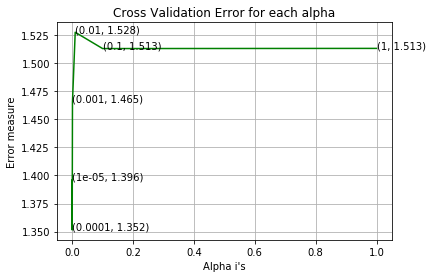

For values of best alpha =  0.0001 The train log loss is: 1.0558617246518194
For values of best alpha =  0.0001 The cross validation log loss is: 1.2552493773064541
For values of best alpha =  0.0001 The test log loss is: 1.1851929541600554


In [26]:
alpha = [10 ** x for x in range(-5, 1)]
cv_log_error=[]
for i in alpha:
    clf=SGDClassifier(loss='hinge',alpha=i)
    clf.fit(train_gene_vect,y_train)
    sig_clf=CalibratedClassifierCV(clf,method='sigmoid')
    sig_clf.fit(train_gene_vect,y_train)
    predict_y=sig_clf.predict_proba(cv_gene_vect)
    cv_log_error.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error,c='g')
for i, txt in enumerate(np.round(cv_log_error,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_gene_vect, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_gene_vect, y_train)

predict_y = sig_clf.predict_proba(train_gene_vect)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_gene_vect)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_gene_vect)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


In [27]:
#as we can see with gene feature our loss is lower than 2. So gene is a very imp feature

In [28]:
#same for variation
# It is also a cateorical feature like gene

In [29]:
v=X_train.Variation.value_counts()
v.head(10)

Deletion                53
Truncating_Mutations    53
Amplification           46
Fusions                 19
Q61R                     3
Overexpression           3
Q61H                     2
A146V                    2
G35R                     2
TMPRSS2-ETV1_Fusion      2
Name: Variation, dtype: int64

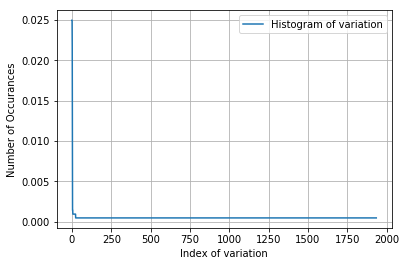

In [30]:
s=sum(v)
h=v.values/s
plt.plot(h,label='Histogram of variation')
plt.xlabel('Index of variation')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()

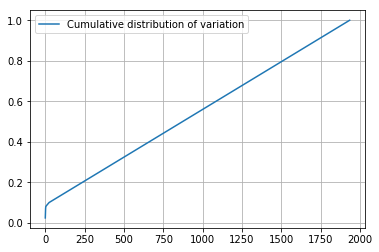

In [31]:
c=np.cumsum(h)
plt.plot(c,label='Cumulative distribution of variation')
plt.legend()
plt.grid()
plt.show()

In [45]:
#one hot encoding of variation feature
cvect=CountVectorizer()
train_var_vect=cvect.fit_transform(X_train.Variation)
cv_var_vect=cvect.transform(x_cv.Variation)
test_var_vect=cvect.transform(X_test.Variation)

In [49]:
train_var_vect.shape

(2124, 1962)

For values of alpha =  1e-05 The log loss is: 1.7426446597182206
For values of alpha =  0.0001 The log loss is: 1.738861618518553
For values of alpha =  0.001 The log loss is: 1.7363068021521402
For values of alpha =  0.01 The log loss is: 1.7407915206267337
For values of alpha =  0.1 The log loss is: 1.7372770474218855
For values of alpha =  1 The log loss is: 1.7372748052591962


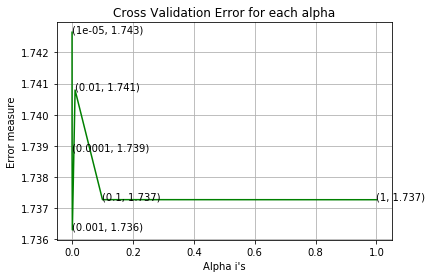

For values of best alpha =  0.001 The train log loss is: 1.1092481794207893
For values of best alpha =  0.001 The cross validation log loss is: 1.7241839109752641
For values of best alpha =  0.001 The test log loss is: 1.6795191887564334


In [53]:
alpha = [10 ** x for x in range(-5, 1)]
cv_log_error=[]
for i in alpha:
    clf=SGDClassifier(loss='hinge',alpha=i)
    clf.fit(train_var_vect,y_train)
    sig_clf=CalibratedClassifierCV(clf,method='sigmoid')
    sig_clf.fit(train_var_vect,y_train)
    predict_y=sig_clf.predict_proba(cv_var_vect)
    cv_log_error.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error,c='g')
for i, txt in enumerate(np.round(cv_log_error,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_var_vect, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_var_vect, y_train)

predict_y = sig_clf.predict_proba(train_var_vect)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_var_vect)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_var_vect)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


In [ ]:
#Not as good as gene but still useful as the loss is lower than 2.

In [ ]:
#Same for Text feature.

In [42]:
# building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = CountVectorizer(min_df=3)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(X_train['TEXT'])
# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names()

train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding = text_vectorizer.transform(X_test['TEXT'])
# don't forget to normalize every feature
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = text_vectorizer.transform(x_cv['TEXT'])
# don't forget to normalize every feature
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

For values of alpha =  1e-05 The log loss is: 1.4387808692831703
For values of alpha =  0.0001 The log loss is: 1.4027332086359838
For values of alpha =  0.001 The log loss is: 1.1700736632622493
For values of alpha =  0.01 The log loss is: 1.228343273332419
For values of alpha =  0.1 The log loss is: 1.5012931583867128
For values of alpha =  1 The log loss is: 1.694725912886072


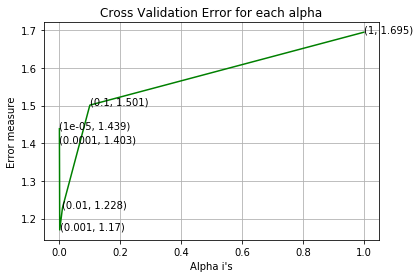

For values of best alpha =  0.001 The train log loss is: 0.7902149167019339
For values of best alpha =  0.001 The cross validation log loss is: 1.1700736632622493
For values of best alpha =  0.001 The test log loss is: 1.1284450233155046


In [43]:
# Train a Logistic regression+Calibration model using text features whicha re on-hot encoded
alpha = [10 ** x for x in range(-5, 1)]
cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_text_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_text_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


In [54]:
def plot_precision_recall_matrix(test_y,predixt_y):
    C=confusion_matrix(test_y,predixt_y)
    a=(((C.T)/(C.sum(axis=1))).T)
    b=(C/C.sum(axis=0))
    labels = [1,2,3,4,5,6,7,8,9]
    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(a, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(b, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

In [55]:
#stacking the features

In [56]:
train_gene_var_onehotCoding = hstack((train_gene_vect,train_var_vect))
test_gene_var_onehotCoding = hstack((test_gene_vect,test_var_vect))
cv_gene_var_onehotCoding = hstack((cv_gene_vect,cv_var_vect))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(cv_df['Class']))

In [57]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2124, 55540)
(number of data points * number of features) in test data =  (665, 55540)
(number of data points * number of features) in cross validation data = (532, 55540)


In [58]:
#Applying Naive Baiyes

Log Loss : 1.2591846225412615
Log Loss : 1.2601820886562125
Log Loss : 1.260338990014433
Log Loss : 1.2885214395137408
Log Loss : 1.2732524392317015
Log Loss : 1.3775171877074102
Log Loss : 1.3457664932658948
Log Loss : 1.309961146155797


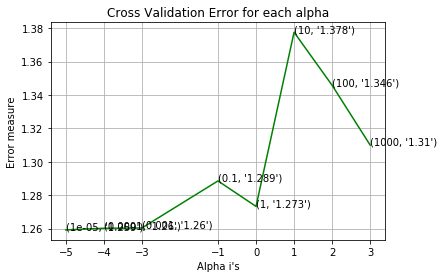

For values of best alpha =  1e-05 The train log loss is: 0.8372797561984482
For values of best alpha =  1e-05 The cross validation log loss is: 1.2591846225412615
For values of best alpha =  1e-05 The test log loss is: 1.2418437116619185


In [59]:
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    clf=MultinomialNB(alpha=i)
    clf.fit(train_x_onehotCoding,train_y)
    sig_clf=CalibratedClassifierCV(clf,method='sigmoid')
    sig_clf.fit(train_x_onehotCoding,train_y)
    predict_proba=sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y,predict_proba,labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, predict_proba))
fix,ax=plt.subplots()
ax.plot(np.log10(alpha),cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)


predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


Log Loss : 1.2591846225412615
Number of missclassified point : 0.40225563909774437
-------------------- Precision matrix (Columm Sum=1) --------------------


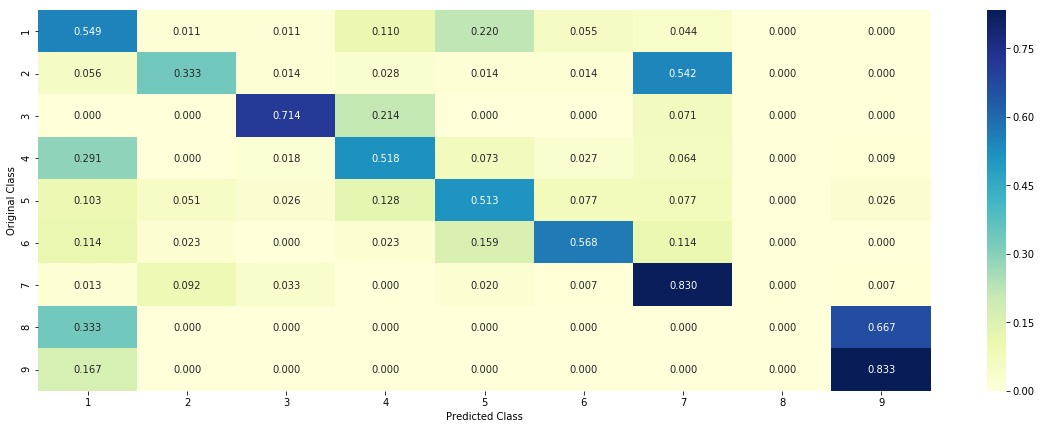

-------------------- Recall matrix (Row sum=1) --------------------


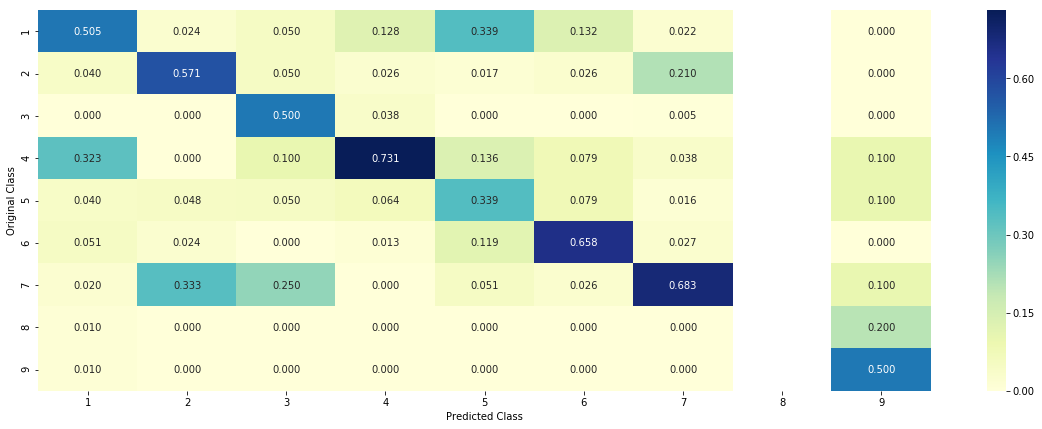

In [60]:
#with best alpha
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(cv_x_onehotCoding)- cv_y))/cv_y.shape[0])
plot_precision_recall_matrix(cv_y, sig_clf.predict(cv_x_onehotCoding.toarray()))

In [61]:
test_point_index = 2
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])

Predicted Class : 4
Predicted Class Probabilities: [[0.0811 0.2379 0.0127 0.481  0.0413 0.0302 0.1063 0.0048 0.0046]]
Actual Class : 4


In [ ]:
#Applying KNN

for alpha = 5
Log Loss : 1.2977803972500301
for alpha = 11
Log Loss : 1.3403149895793054
for alpha = 15
Log Loss : 1.3284733839809646
for alpha = 21
Log Loss : 1.4294963446994728
for alpha = 31
Log Loss : 1.466325208713968
for alpha = 41
Log Loss : 1.4413387266344
for alpha = 51
Log Loss : 1.3971538400398185
for alpha = 99
Log Loss : 1.384157765894665


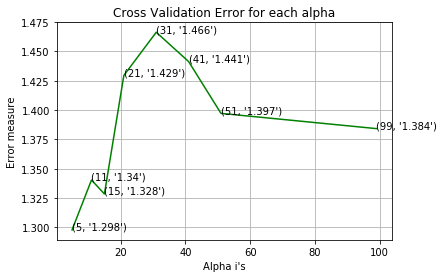

For values of best alpha =  5 The train log loss is: 1.042130219325112
For values of best alpha =  5 The cross validation log loss is: 1.2977803972500301
For values of best alpha =  5 The test log loss is: 1.2732921463526252


In [77]:
alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


Log Loss : 1.384157765894665
Number of missclassified point : 0.4266917293233083
-------------------- Precision matrix (Columm Sum=1) --------------------


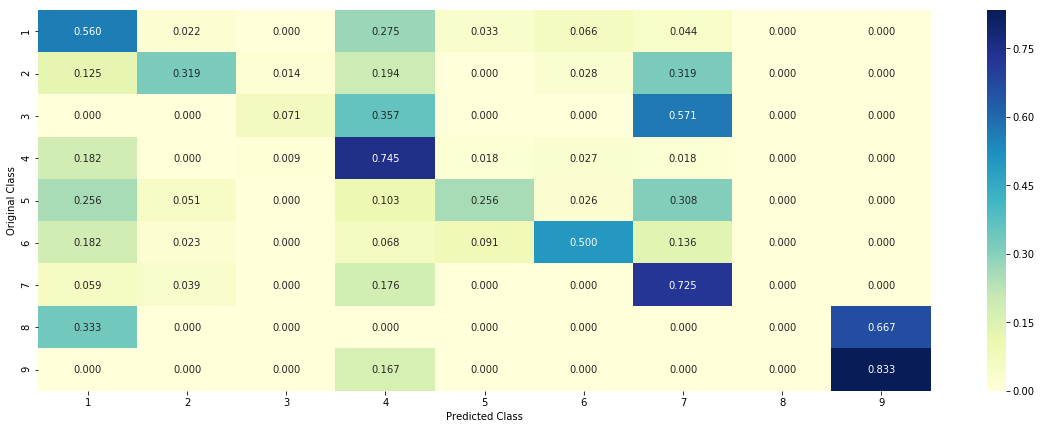

-------------------- Recall matrix (Row sum=1) --------------------


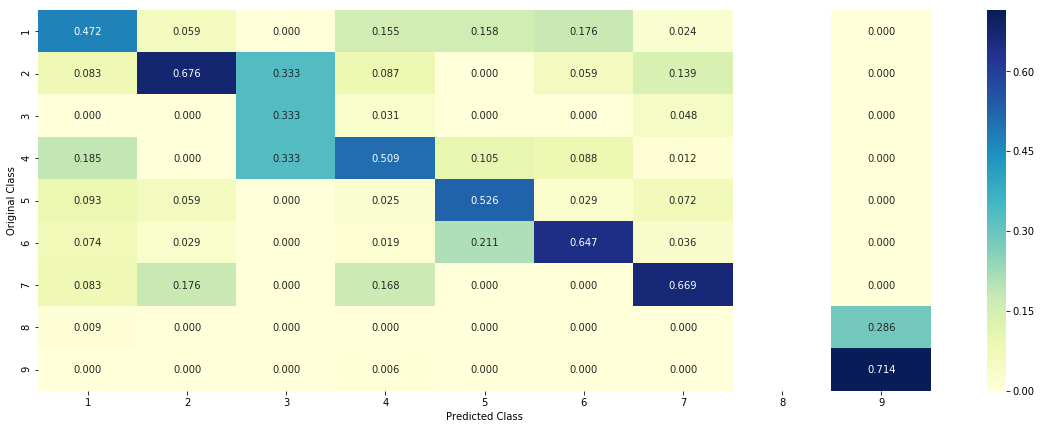

In [78]:
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(cv_x_onehotCoding)- cv_y))/cv_y.shape[0])
plot_precision_recall_matrix(cv_y, sig_clf.predict(cv_x_onehotCoding.toarray()))

In [73]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

test_point_index = 1
predicted_cls = sig_clf.predict(test_x_onehotCoding[0])
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_onehotCoding[test_point_index], alpha[best_alpha])
print("The ",alpha[best_alpha]," nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 7
Actual Class : 6
The  5  nearest neighbours of the test points belongs to classes [6 6 6 6 6]
Fequency of nearest points : Counter({6: 5})


In [62]:
#Applying Logistic Regression

for alpha = 1e-06
Log Loss : 1.3491432043716447
for alpha = 1e-05
Log Loss : 1.396454517880804
for alpha = 0.0001
Log Loss : 1.3149572517329693
for alpha = 0.001
Log Loss : 1.092609967738125
for alpha = 0.01
Log Loss : 1.1472339914040297
for alpha = 0.1
Log Loss : 1.4803587613391118
for alpha = 1
Log Loss : 1.6983869666070783
for alpha = 10
Log Loss : 1.727695935185304
for alpha = 100
Log Loss : 1.7309727163381932


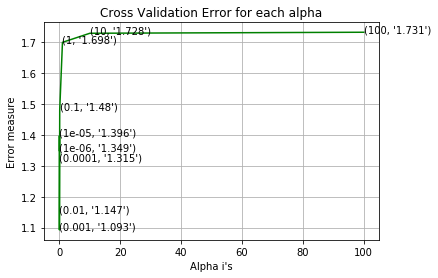

For values of best alpha =  0.001 The train log loss is: 0.6553917651797557
For values of best alpha =  0.001 The cross validation log loss is: 1.092609967738125
For values of best alpha =  0.001 The test log loss is: 1.0498035517290887


In [79]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log Loss : 1.7309727163381932
Number of missclassified point : 0.34774436090225563
-------------------- Precision matrix (Columm Sum=1) --------------------


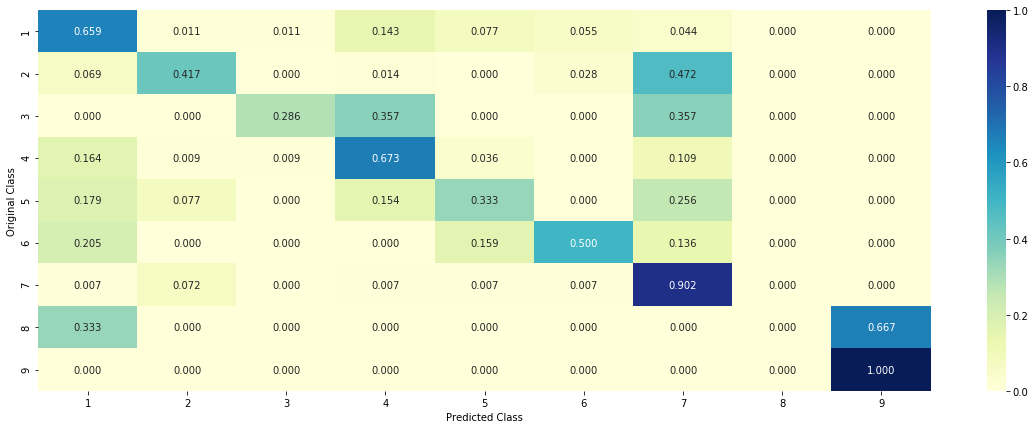

-------------------- Recall matrix (Row sum=1) --------------------


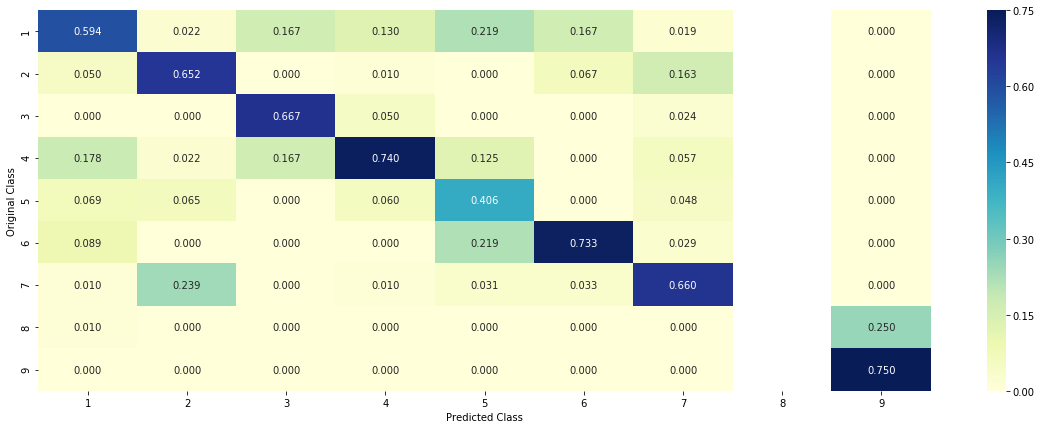

In [80]:
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(cv_x_onehotCoding)- cv_y))/cv_y.shape[0])
plot_precision_recall_matrix(cv_y, sig_clf.predict(cv_x_onehotCoding.toarray()))

In [82]:
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])

Predicted Class : 4
Predicted Class Probabilities: [[0.078  0.1325 0.0203 0.5665 0.0481 0.0158 0.1272 0.0065 0.005 ]]
Actual Class : 4


# LR is better